# Préparation du dataset

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout, experimental 
#from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("La version de tensorflow utilisé est:",tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

La version de tensorflow utilisé est: 2.5.0
Num GPUs Available:  1


In [4]:
df = pd.read_csv('data/cleaned/description_cleaned_spacy.csv')
df.head()

,uniq_id,image,description,description_clean,cat_1
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,"['key', 'feature', 'elegance', 'polyester', 'm...",home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,"['specification', 'sathiyas', 'cotton', 'bath'...",baby care
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,"['key', 'feature', 'eurospa', 'cotton', 'terry...",baby care
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,"['key', 'feature', 'santosh', 'royal', 'fashio...",home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,"['key', 'feature', 'jaipur', 'print', 'cotton'...",home furnishing


In [5]:
import pickle 
from sklearn import preprocessing

try:
    with open('data/cleaned/description_cleaned_spacy.pkl', 'rb') as f1:
        data = pickle.load(f1)
except:
    data = pd.read_csv('data/cleaned/description_cleaned_spacy.csv')

data = data[['image','cat_1']].rename(columns={"cat_1": "label_name"})

# Definir la liste des catégories
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["label_name"])

# Récuperer la liste des libellé des catégories
list_labels = data.label_name.unique()

# Definir le nombre de catégories
NBCLASS_ = len(data.label_name.unique())

data

,image,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing,4
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,baby care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,baby care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,baby care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,baby care,0


# Recuprer la liste de path des train et test files

In [6]:
from glob import glob
path_train = 'data/cleaned/Images/train/'
path_test = 'data/cleaned/Images/test/'

data_train_path = glob(path_train+'*/*.jp*')
data_test_path = glob(path_test+'*/*.jp*')

def data_fct(path) :
    data = pd.DataFrame()
    data["image_path"] = path
    data["image_path"] = data["image_path"].str.replace('\\','/') #transforme les \\ en /
    data["label_name"] = data["image_path"].str.split('/',expand=True)[4] #
    return data

data_train = data_fct(data_train_path)
data_test = data_fct(data_test_path)


C:\Users\eleor\AppData\Local\Temp\ipykernel_21132\1771213865.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data["image_path"] = data["image_path"].str.replace('\\','/')


In [7]:
data_train['label'] = data_train.label_name.map({'baby_care':0, 'beauty_and_personal_care':1, 'computers':2,
       'home_decor_&_festive_needs':3, 'home_furnishing':4, 'kitchen_&_dining':5, 'watches':6})

data_test['label'] = data_test.label_name.map({'baby_care':0, 'beauty_and_personal_care':1, 'computers':2,
       'home_decor_&_festive_needs':3, 'home_furnishing':4, 'kitchen_&_dining':5, 'watches':6})

data_train.sample(10)

,image_path,label_name,label
317,data/cleaned/Images/train/computers/a8e2698d5b...,computers,2
457,data/cleaned/Images/train/home_decor_&_festive...,home_decor_&_festive_needs,3
773,data/cleaned/Images/train/watches/700dfd088162...,watches,6
796,data/cleaned/Images/train/watches/8fc61e0dae24...,watches,6
46,data/cleaned/Images/train/baby_care/6ed34e1ab8...,baby_care,0
799,data/cleaned/Images/train/watches/920154acbe49...,watches,6
362,data/cleaned/Images/train/home_decor_&_festive...,home_decor_&_festive_needs,3
817,data/cleaned/Images/train/watches/c705a5735a94...,watches,6
286,data/cleaned/Images/train/computers/70af4c3c05...,computers,2
558,data/cleaned/Images/train/home_furnishing/ad55...,home_furnishing,4


In [8]:
data_test.label_name.value_counts()

baby_care                     30
beauty_and_personal_care      30
computers                     30
home_decor_&_festive_needs    30
home_furnishing               30
kitchen_&_dining              30
watches                       30
Name: label_name, dtype: int64

In [9]:
data.groupby("label").count()

,image,label_name
label,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


# Etape 1 : étude de faisabilité

## Création du modèle pré-entraîné

In [10]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Création des features des images

In [11]:
images_features = []
i=0 
for image_file in data["image"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img('data/source/raw_folder_image/'+image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


C:\Users\eleor\anaconda3\envs\py3GPU_nltk\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

## Réduction dimension et analyse

### Réduction de dimension PCA

In [12]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [13]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=50, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :             6.04 secondes


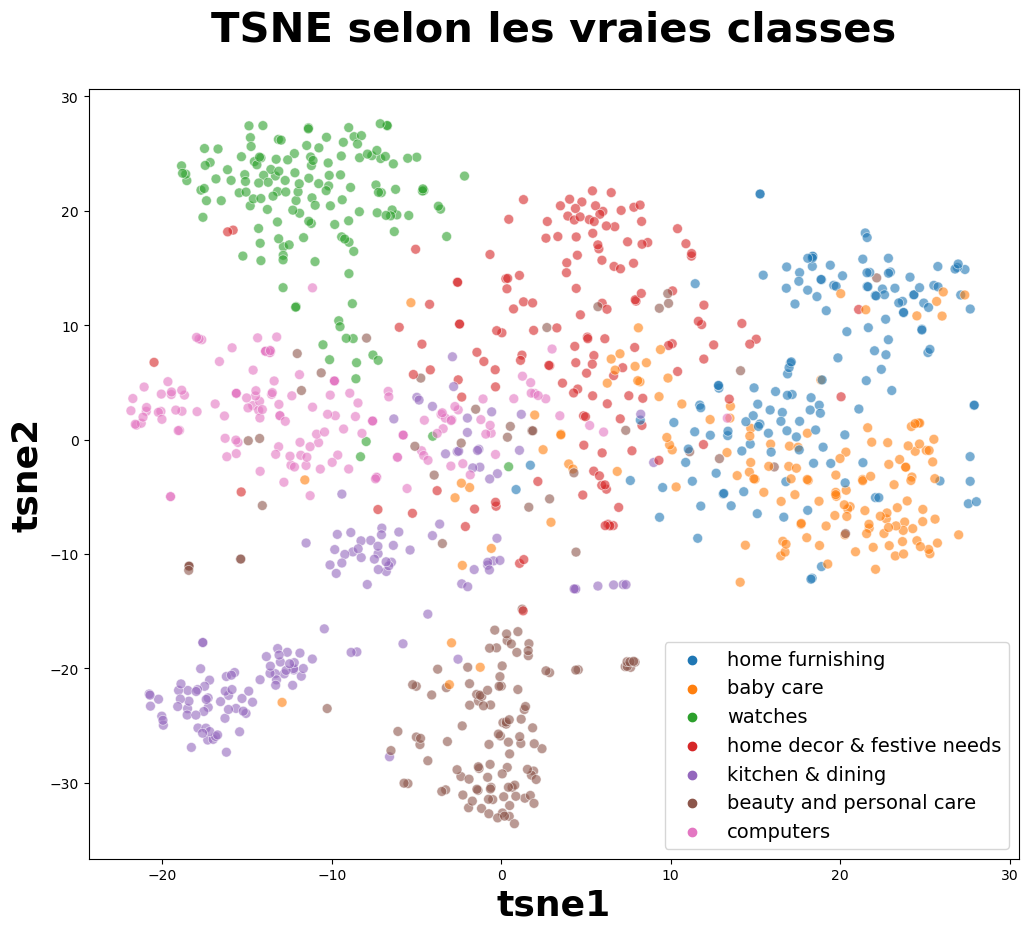

In [14]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(12,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors= NBCLASS_), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief"
)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data

### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement


In [15]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters= NBCLASS_ , n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

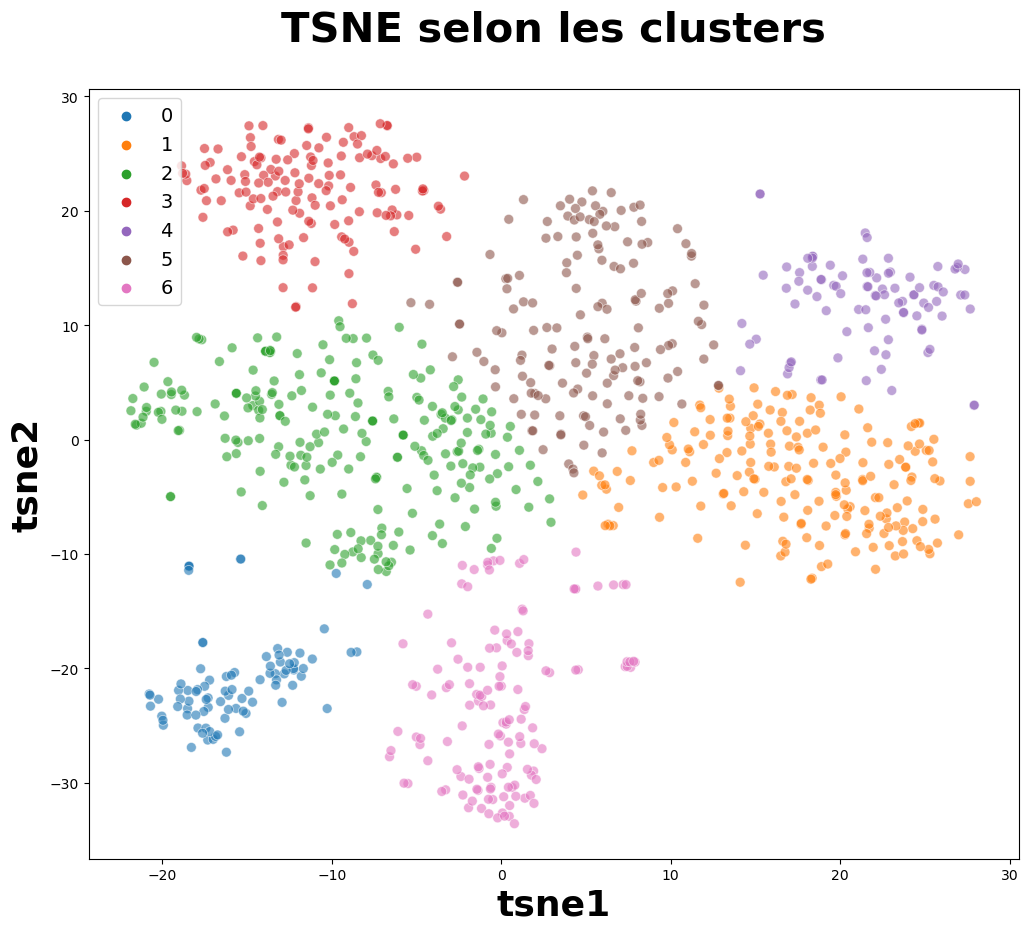

ARI :  0.4902812743979463


In [16]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(12,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors= NBCLASS_ ), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

* Analyse : le modèle pré-entraîné confond "cloud" avec de la neige ...

### Analyse par classes

In [17]:
conf_mat = metrics.confusion_matrix(data.label, cls.labels_)
print(conf_mat)

[[  1 111   6   0   8  20   4]
 [  7   4  17   0   2   9 111]
 [  0   1 137   1   0  11   0]
 [  0  16  16   3   4 108   3]
 [  0  67   2   0  77   4   0]
 [ 80   1  47   0   0   3  19]
 [  0   0  14 136   0   0   0]]


In [18]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [19]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [5 0 2 6 4 3 1]
[[111   4   6  20   8   1   0]
 [  4 111  17   9   2   7   0]
 [  1   0 137  11   0   0   1]
 [ 16   3  16 108   4   0   3]
 [ 67   0   2   4  77   0   0]
 [  1  19  47   3   0  80   0]
 [  0   0  14   0   0   0 136]]

              precision    recall  f1-score   support

           0       0.56      0.74      0.63       150
           1       0.81      0.74      0.77       150
           2       0.57      0.91      0.70       150
           3       0.70      0.72      0.71       150
           4       0.85      0.51      0.64       150
           5       0.91      0.53      0.67       150
           6       0.97      0.91      0.94       150

    accuracy                           0.72      1050
   macro avg       0.77      0.72      0.72      1050
weighted avg       0.77      0.72      0.72      1050



<AxesSubplot:>

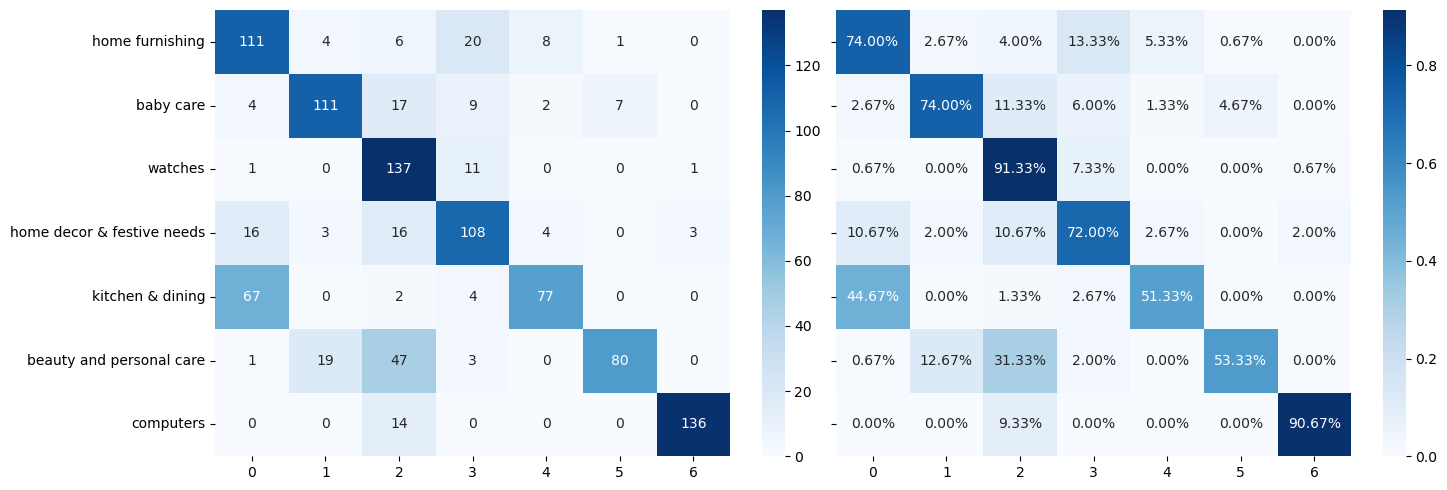

In [20]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in data.label_name.unique()],
                  columns = [i for i in "0123456"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), tight_layout=True,sharey=True)
sns.heatmap(df_cm, annot=True,fmt='d', cmap="Blues",ax= ax1)
sns.heatmap(df_cm.apply(lambda x:x/x.sum(),axis=1), annot=True,fmt='.2%', cmap="Blues",ax= ax2)

* La classe la moins bien prédite est "shine" (CF exemple ci-dessus : confond la neige avec un nuage)

# Etape 2 : classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


## Création du modèle de classification

In [111]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NBCLASS_, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer= 'adam',#'rmsprop', 
                  metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [112]:
data

,image,label_name,label
0,833a87b0af3b84fe246d2ebf271af177.jpg,computers,2
1,55195de3873fffaa9e37b041533d7305.jpg,kitchen & dining,5
2,44b963eb856b4831dfdd21b666593c95.jpg,computers,2
3,98ad5b99ad96695568d8f143b11ab740.jpg,beauty and personal care,1
4,29b1ca231e10d5269516b80bf9d0dffc.jpg,watches,6
...,...,...,...
1045,394c2c627914e1eed9b8ac343583a679.jpg,computers,2
1046,3bc98543c7dd0d8fce5b8185b4a58c43.jpg,baby care,0
1047,7dd5e83e2108a97659577e50879f9d9f.jpg,baby care,0
1048,be0f39341d771aac57084970f1ed6425.jpg,baby care,0


In [113]:
data_train

,image_path,label_name,label
0,data/cleaned/Images/train/baby_care/057836ecde...,baby_care,0
1,data/cleaned/Images/train/baby_care/0906fd9cc6...,baby_care,0
2,data/cleaned/Images/train/baby_care/093bcad64d...,baby_care,0
3,data/cleaned/Images/train/baby_care/0991e8d8f8...,baby_care,0
4,data/cleaned/Images/train/baby_care/0bff0eda7a...,baby_care,0
...,...,...,...
835,data/cleaned/Images/train/watches/f2aaeda52ac1...,watches,6
836,data/cleaned/Images/train/watches/f355cc1ccb08...,watches,6
837,data/cleaned/Images/train/watches/f74476ba6436...,watches,6
838,data/cleaned/Images/train/watches/fc93a41f31c4...,watches,6


## Approche préparation initiale des images

In [114]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np_train = image_prep_fct(data_train)
print(images_np_train.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(840, 224, 224, 3)
(210, 224, 224, 3)


In [115]:
X = images_np_train
y = to_categorical(data_train['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [116]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(630, 224, 224, 3)

In [117]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [118]:
%%time
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
10/10 [==============================] - 2s 155ms/step - loss: 5.9338 - accuracy: 0.3651 - val_loss: 1.6494 - val_accuracy: 0.6714

Epoch 00001: val_loss improved from inf to 1.64941, saving model to .\model1_best_weights.h5
Epoch 2/50
10/10 [==============================] - 1s 141ms/step - loss: 1.9460 - accuracy: 0.6556 - val_loss: 1.3508 - val_accuracy: 0.7714

Epoch 00002: val_loss improved from 1.64941 to 1.35077, saving model to .\model1_best_weights.h5
Epoch 3/50
10/10 [==============================] - 1s 141ms/step - loss: 1.3139 - accuracy: 0.7333 - val_loss: 1.2411 - val_accuracy: 0.8190

Epoch 00003: val_loss improved from 1.35077 to 1.24114, saving model to .\model1_best_weights.h5
Epoch 4/50
10/10 [==============================] - 1s 141ms/step - loss: 0.8849 - accuracy: 0.8079 - val_loss: 1.0953 - val_accuracy: 0.8000

Epoch 00004: val_loss improved from 1.24114 to 1.09525, saving model to .\model1_best_weights.h5
Epoch 5/50
10/10 [==========================

In [119]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 [==============================] - 1s 52ms/step - loss: 0.0224 - accuracy: 0.9984
Training Accuracy: 0.9984

7/7 [==============================] - 0s 50ms/step - loss: 1.0161 - accuracy: 0.8095
Validation Accuracy:  0.8095


In [120]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8048
Test Accuracy       :  0.7762


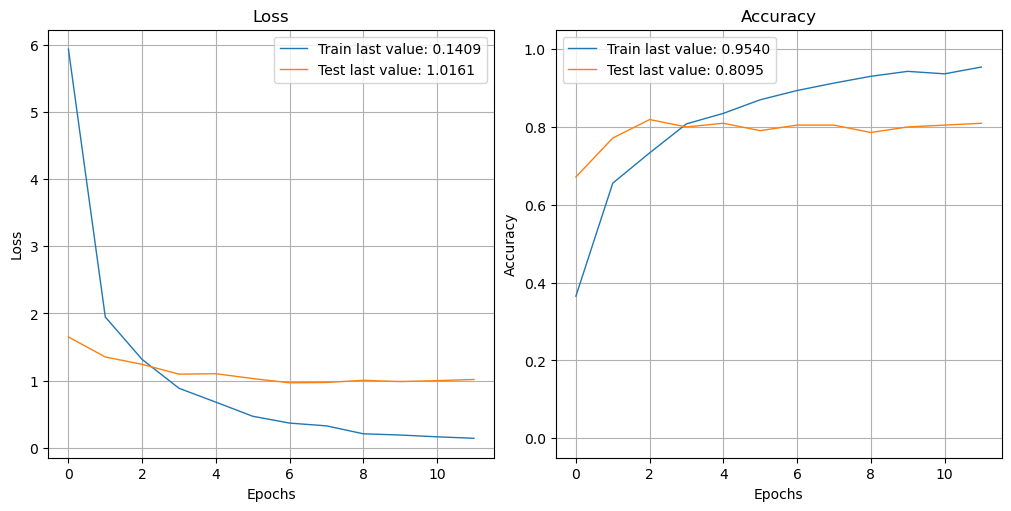

In [121]:
try:
    from plot_keras_history import show_history, plot_history
    import matplotlib.pyplot as plt

    show_history(history1)
    plot_history(history1, path="standard.png")
    plt.close()
except:
    epochs_range = range(11)
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history1.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history1.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history1.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history1.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [122]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

[0 2 6 2 4 1 1 0 2 4 2 6 1 6 5 2 1 1 4 3 4 2 6 6 3 3 0 1 2 4 6 3 4 2 6 5 2
 5 6 3 0 2 6 5 2 0 1 6 4 6 5 3 3 3 5 3 5 4 4 0 4 0 6 6 2 5 0 0 1 3 5 3 5 1
 4 6 2 4 5 1 4 0 5 4 1 5 2 2 3 1 3 5 4 3 5 4 6 0 2 0 3 4 5 1 3 3 6 1 1 4 3
 0 3 2 5 2 1 6 1 4 5 5 3 0 0 3 2 6 3 6 5 1 2 6 6 1 1 5 3 4 3 3 5 1 0 4 5 0
 5 4 0 6 0 0 4 0 2 4 1 2 4 0 5 2 4 1 5 2 4 1 0 2 1 6 4 2 4 3 0 0 6 2 0 4 6
 5 0 2 3 1 6 0 6 1 5 0 5 0 2 3 1 6 1 2 1 3 6 3 6 5]

[4 2 6 2 4 1 1 0 2 4 2 6 1 6 5 2 1 1 0 3 4 2 6 6 3 5 0 2 3 1 6 3 4 2 6 5 1
 5 6 3 4 2 6 5 1 0 1 6 4 6 5 3 3 0 0 3 0 4 3 0 3 0 6 6 1 5 0 0 1 3 5 3 5 1
 0 6 5 4 5 1 4 4 5 0 1 5 2 2 3 1 3 5 4 3 5 0 6 0 2 0 3 4 3 1 3 3 6 1 1 0 3
 0 3 2 5 2 1 6 1 4 3 5 4 0 0 3 2 6 3 6 5 1 2 6 6 1 1 5 3 4 3 3 5 1 0 4 5 1
 5 4 0 6 0 4 4 0 4 4 1 2 0 0 5 2 0 1 3 5 4 1 0 3 3 6 4 2 4 3 0 4 6 2 0 4 6
 5 1 1 3 1 6 0 6 1 2 0 5 0 2 3 0 6 4 4 0 3 6 3 6 5]


In [123]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[23  2  0  0  5  0  0]
 [ 2 25  1  1  1  0  0]
 [ 0  4 20  2  2  2  0]
 [ 1  0  0 27  1  1  0]
 [ 7  1  0  2 20  0  0]
 [ 2  0  1  3  0 24  0]
 [ 0  0  0  0  0  0 30]]


In [124]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[23  2  0  0  5  0  0]
 [ 2 25  1  1  1  0  0]
 [ 0  4 20  2  2  2  0]
 [ 1  0  0 27  1  1  0]
 [ 7  1  0  2 20  0  0]
 [ 2  0  1  3  0 24  0]
 [ 0  0  0  0  0  0 30]]

              precision    recall  f1-score   support

           0       0.66      0.77      0.71        30
           1       0.78      0.83      0.81        30
           2       0.91      0.67      0.77        30
           3       0.77      0.90      0.83        30
           4       0.69      0.67      0.68        30
           5       0.89      0.80      0.84        30
           6       1.00      1.00      1.00        30

    accuracy                           0.80       210
   macro avg       0.81      0.80      0.80       210
weighted avg       0.81      0.80      0.80       210



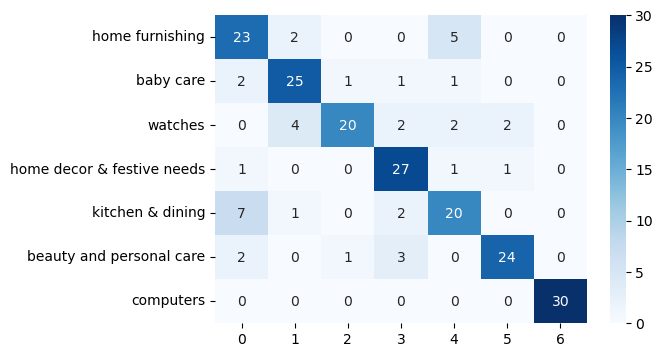

In [125]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues");

</Br>

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [126]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [127]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [128]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(224, 224),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [129]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data_train, datagen_train, data_type='training')
val_flow = data_flow_fct(data_train, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [130]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [131]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [132]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
20/20 [==============================] - 10s 465ms/step - loss: 3.0939 - accuracy: 0.5143 - val_loss: 11.5387 - val_accuracy: 0.2905

Epoch 00001: val_loss improved from inf to 11.53874, saving model to .\model2_best_weights.h5
Epoch 2/50
20/20 [==============================] - 9s 439ms/step - loss: 1.0472 - accuracy: 0.7587 - val_loss: 10.9662 - val_accuracy: 0.2429

Epoch 00002: val_loss improved from 11.53874 to 10.96623, saving model to .\model2_best_weights.h5
Epoch 3/50
20/20 [==============================] - 9s 444ms/step - loss: 0.6296 - accuracy: 0.8381 - val_loss: 8.9829 - val_accuracy: 0.3143

Epoch 00003: val_loss improved from 10.96623 to 8.98293, saving model to .\model2_best_weights.h5
Epoch 4/50
20/20 [==============================] - 9s 437ms/step - loss: 0.4688 - accuracy: 0.8683 - val_loss: 9.3681 - val_accuracy: 0.3238

Epoch 00004: val_loss did not improve from 8.98293
Epoch 5/50
20/20 [==============================] - 9s 447ms/step - loss: 0.4040 - 

In [133]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 7s 322ms/step - loss: 0.0514 - accuracy: 0.9873
Training Accuracy   : 0.9873

7/7 [==============================] - 2s 299ms/step - loss: 8.7178 - accuracy: 0.3048
Validation Accuracy :  0.3048


In [134]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.2714
Test Accuracy       :  0.6857


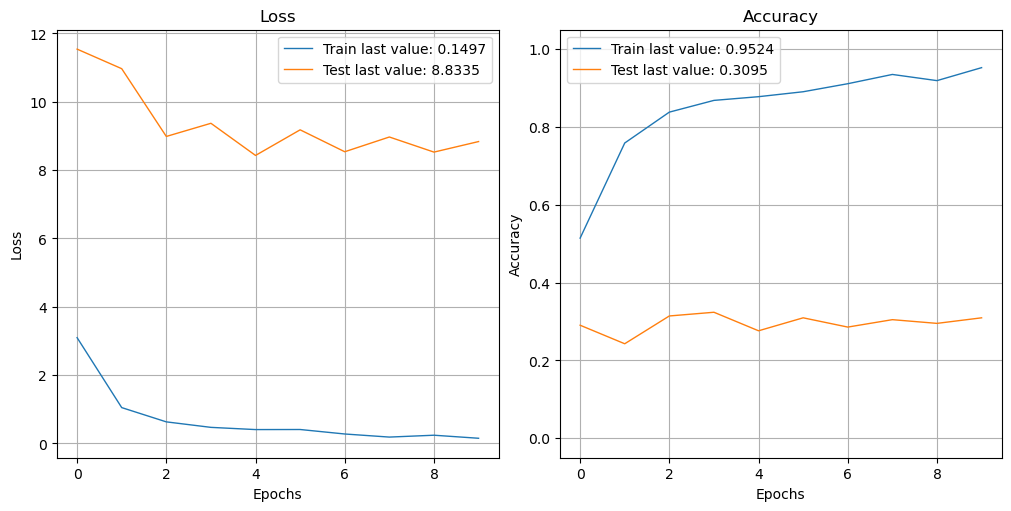

In [135]:
try:
    from plot_keras_history import show_history, plot_history
    import matplotlib.pyplot as plt

    show_history(history2)
    plot_history(history2, path="standard.png")
    plt.close()
except:
    epochs_range = range(len(history2.history['loss']))

    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history2.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history2.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history2.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history2.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]

[5 4 4 4 5 5 4 3 4 4 4 4 2 3 4 4 4 3 4 2 4 4 4 2 4 4 4 4 2 3 2 3 1 1 2 1 1
 1 3 1 5 1 1 1 1 1 1 1 1 3 1 1 1 2 2 4 1 1 1 1 2 2 2 2 5 2 2 5 2 2 2 2 2 2
 2 2 2 5 2 2 2 2 2 2 2 2 2 2 2 5 3 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 4
 3 6 3 3 3 5 3 3 2 4 4 4 4 4 4 4 4 4 2 4 4 4 5 4 4 4 4 4 4 4 4 4 3 4 4 3 4
 4 4 5 5 5 3 5 5 2 5 5 5 5 5 5 5 5 5 5 2 5 3 5 5 5 5 3 5 5 5 5 5 6 6 6 6 6
 6 6 3 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6]
Correspondance des clusters :  [0 1 2 3 4 5 6]


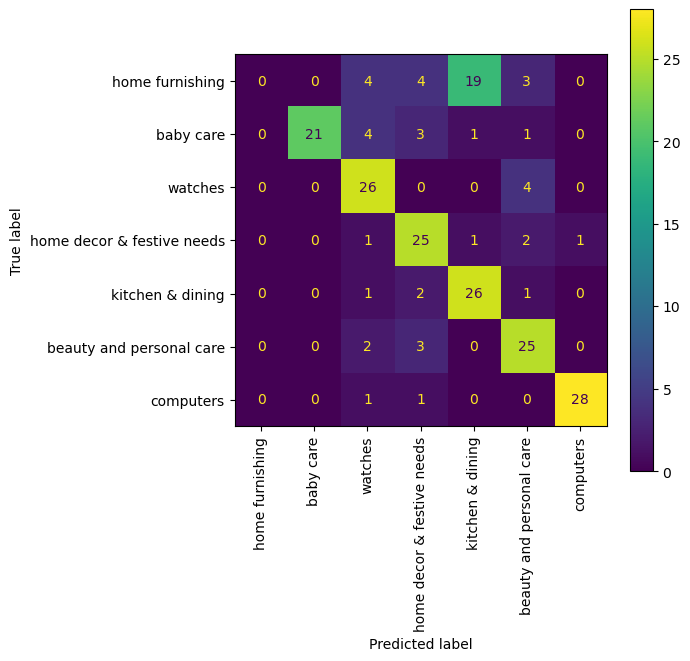

In [223]:
y_test_num = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model2.predict(X_test), axis=1)
y_test_num = np.argmax(y_test, axis=1)
print(y_test_num)
print()
print(y_test_pred)

y_test_pred_transform = conf_mat_transform(y_test_num, y_test_pred)
conf_mat = metrics.confusion_matrix(y_test_num, y_test_pred_transform)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=list_labels)
disp.plot()
plt.rcParams['figure.figsize']=[6,6]
plt.xticks(rotation=90)
plt.show()

In [224]:
print(metrics.classification_report(y_test_num, y_test_pred_transform))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       1.00      0.70      0.82        30
           2       0.67      0.87      0.75        30
           3       0.66      0.83      0.74        30
           4       0.55      0.87      0.68        30
           5       0.69      0.83      0.76        30
           6       0.97      0.93      0.95        30

    accuracy                           0.72       210
   macro avg       0.65      0.72      0.67       210
weighted avg       0.65      0.72      0.67       210



C:\Users\eleor\anaconda3\envs\py3GPU_nltk\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eleor\anaconda3\envs\py3GPU_nltk\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eleor\anaconda3\envs\py3GPU_nltk\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

In [136]:
batch_size = 32
try:
    def dataset_fct(path, validation_split=0, data_type=None) :
        dataset = tf.keras.utils.image_dataset_from_directory(
                        path, labels='inferred', label_mode='categorical',
                        class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                        validation_split=validation_split, subset=data_type
                        )
        return dataset
    
    # test de la création de la fonction
    dataset_fct(path_train, validation_split=0.25, data_type='training')
    
except:
    def dataset_fct(path, validation_split=0, data_type=None) :
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
                        path, labels='inferred', label_mode='categorical',
                        class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                        validation_split=validation_split, subset=data_type
                        )
        return dataset

In [137]:
dataset_train = dataset_fct(path_train, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path_train, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [138]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [139]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [140]:
with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
20/20 [==============================] - 2s 89ms/step - loss: 6.5008 - accuracy: 0.3794 - val_loss: 1.8689 - val_accuracy: 0.7286

Epoch 00001: val_loss improved from inf to 1.86890, saving model to .\model3_best_weights.h5
Epoch 2/50
20/20 [==============================] - 2s 82ms/step - loss: 2.0483 - accuracy: 0.7063 - val_loss: 1.3365 - val_accuracy: 0.7857

Epoch 00002: val_loss improved from 1.86890 to 1.33648, saving model to .\model3_best_weights.h5
Epoch 3/50
20/20 [==============================] - 2s 82ms/step - loss: 1.2998 - accuracy: 0.7683 - val_loss: 1.2175 - val_accuracy: 0.8048

Epoch 00003: val_loss improved from 1.33648 to 1.21749, saving model to .\model3_best_weights.h5
Epoch 4/50
20/20 [==============================] - 2s 82ms/step - loss: 0.8179 - accuracy: 0.8048 - val_loss: 1.0551 - val_accuracy: 0.8143

Epoch 00004: val_loss improved from 1.21749 to 1.05505, saving model to .\model3_best_weights.h5
Epoch 5/50
20/20 [==============================

In [141]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 1s 61ms/step - loss: 0.0042 - accuracy: 1.0000
Training Accuracy   : 1.0000

7/7 [==============================] - 0s 54ms/step - loss: 0.8858 - accuracy: 0.8524
Validation Accuracy :  0.8524


In [142]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8619
Test Accuracy       :  0.7905


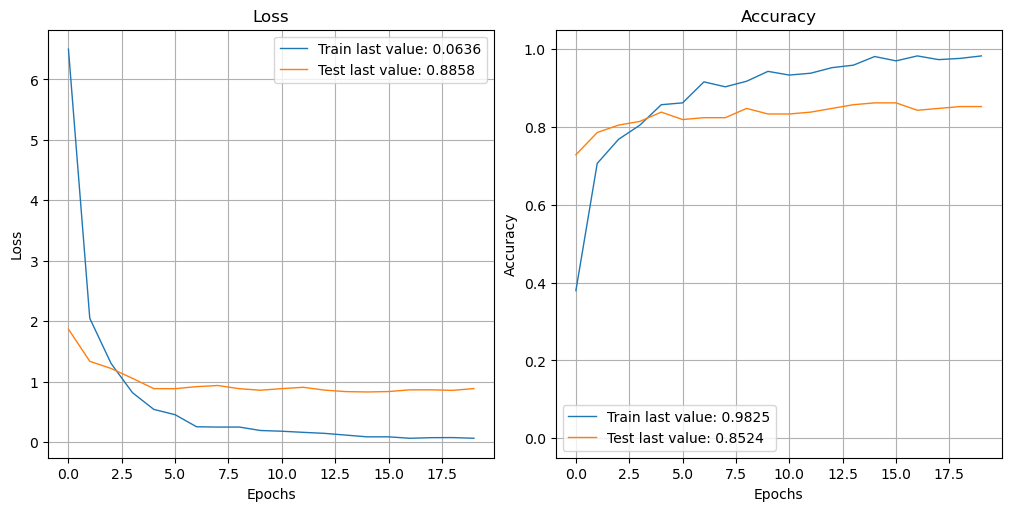

In [143]:
try:
    from plot_keras_history import show_history, plot_history
    import matplotlib.pyplot as plt

    show_history(history3)
    plot_history(history3, path="standard.png")
    plt.close()
except:
    epochs_range = range(len(history3.history['loss']))

    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history3.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history3.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history3.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history3.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

Correspondance des clusters :  [0 1 2 3 4 5 6]


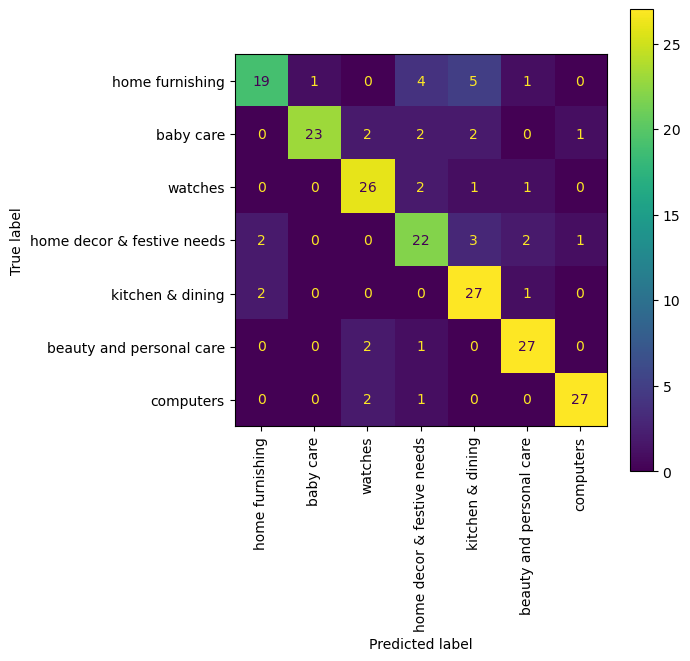

In [225]:
y_test_pred = np.argmax(model3.predict(X_test), axis=1)

y_test_pred_transform = conf_mat_transform(y_test_num, y_test_pred)
conf_mat = metrics.confusion_matrix(y_test_num, y_test_pred_transform)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=list_labels)
disp.plot()
plt.rcParams['figure.figsize']=[6,6]
plt.xticks(rotation=90)
plt.show()

In [226]:
print(metrics.classification_report(y_test_num, y_test_pred_transform))

              precision    recall  f1-score   support

           0       0.83      0.63      0.72        30
           1       0.96      0.77      0.85        30
           2       0.81      0.87      0.84        30
           3       0.69      0.73      0.71        30
           4       0.71      0.90      0.79        30
           5       0.84      0.90      0.87        30
           6       0.93      0.90      0.92        30

    accuracy                           0.81       210
   macro avg       0.82      0.81      0.81       210
weighted avg       0.82      0.81      0.81       210



## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [144]:
batch_size = 32

try:
    def dataset_fct(path, validation_split=0, data_type=None) :
        dataset = tf.keras.utils.image_dataset_from_directory(
                        path, labels='inferred', label_mode='categorical',
                        class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                        validation_split=validation_split, subset=data_type
                        )
        return dataset
    
    # test de la création de la fonction
    dataset_fct(path_train, validation_split=0.25, data_type='training')
    
except:
    def dataset_fct(path, validation_split=0, data_type=None) :
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
                        path, labels='inferred', label_mode='categorical',
                        class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                        validation_split=validation_split, subset=data_type
                        )
        return dataset

In [145]:
dataset_train = dataset_fct(path_train, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path_train, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [146]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label



In [147]:
import importlib.util
test_spec = importlib.util.find_spec("tensorflow.keras.layers.RandomFlip")
test_spec is not None

False

In [148]:
def create_model_fct2() :
    import importlib.util
    test_spec = importlib.util.find_spec("tensorflow.keras.layers.RandomFlip")
    
    if test_spec is not None:
        # Data augmentation
        data_augmentation = Sequential([
            tf.keras.layers.RandomFlip("horizontal", input_shape=(224, 224, 3)), #A preprocessing layer which randomly flips images during training.
            tf.keras.layers.RandomRotation(0.1), #A preprocessing layer which randomly rotates images during training.
            tf.keras.layers.RandomZoom(0.1), # A preprocessing layer which randomly zooms images during training
            # tf.keras.layers.Rescaling(1./127.5, offset=-1.0)
          ])
        
        # Récupération modèle pré-entraîné
        model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
        for layer in model_base.layers:
            layer.trainable = False

        # Définition du nouveau modèle
        model = Sequential([
                    data_augmentation,
                    
                    # To rescale an input in the [0, 255] range to be in the [0, 1] range, you would pass scale=1./255.
                    # To rescale an input in the [0, 255] range to be in the [-1, 1] range, you would pass scale=1./127.5, offset=-1.
                    tf.keras.layers.Rescaling(1./127.5, offset=-1),
                    model_base,
                    GlobalAveragePooling2D(),
                    Dense(256, activation='relu'),
                    Dropout(0.5),
                    Dense(NBCLASS_, activation='softmax')
                    ])
    
    else:
        # Data augmentation
        data_augmentation = Sequential([
            experimental.preprocessing.RandomFlip("horizontal", input_shape=(224, 224, 3)),
            experimental.preprocessing.RandomRotation(0.1),
            experimental.preprocessing.RandomZoom(0.1),
            # experimental.preprocessing.Rescaling(1./127.5, offset=-1.0)
        ])
        
        # Récupération modèle pré-entraîné
        model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
        for layer in model_base.layers:
            layer.trainable = False

        # Définition du nouveau modèle
        model = Sequential([
                    data_augmentation,
                    # To rescale an input in the [0, 255] range to be in the [0, 1] range, you would pass scale=1./255.
                    # To rescale an input in the [0, 255] range to be in the [-1, 1] range, you would pass scale=1./127.5, offset=-1.
                    experimental.preprocessing.Rescaling(1./127.5, offset=-1),
                    model_base,
                    GlobalAveragePooling2D(),
                    Dense(256, activation='relu'),
                    Dropout(0.5),
                    Dense(NBCLASS_, activation='softmax')
                    ])

    

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())

    return model


In [149]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 7)               

In [150]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [151]:
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
20/20 [==============================] - 3s 92ms/step - loss: 1.9189 - accuracy: 0.2476 - val_loss: 1.4440 - val_accuracy: 0.5857

Epoch 00001: val_loss improved from inf to 1.44402, saving model to .\model4_best_weights.h5
Epoch 2/50
20/20 [==============================] - 2s 84ms/step - loss: 1.4229 - accuracy: 0.5079 - val_loss: 1.1640 - val_accuracy: 0.6429

Epoch 00002: val_loss improved from 1.44402 to 1.16398, saving model to .\model4_best_weights.h5
Epoch 3/50
20/20 [==============================] - 2s 84ms/step - loss: 1.2188 - accuracy: 0.6048 - val_loss: 0.9600 - val_accuracy: 0.7429

Epoch 00003: val_loss improved from 1.16398 to 0.96003, saving model to .\model4_best_weights.h5
Epoch 4/50
20/20 [==============================] - 2s 85ms/step - loss: 1.0566 - accuracy: 0.6810 - val_loss: 0.8534 - val_accuracy: 0.7857

Epoch 00004: val_loss improved from 0.96003 to 0.85338, saving model to .\model4_best_weights.h5
Epoch 5/50
20/20 [==============================

In [152]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 1s 60ms/step - loss: 0.2969 - accuracy: 0.9016
Training Accuracy   : 0.9016

7/7 [==============================] - 0s 54ms/step - loss: 0.6075 - accuracy: 0.8048
Validation Accuracy :  0.8048


In [153]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8143
Test Accuracy       :  0.7762


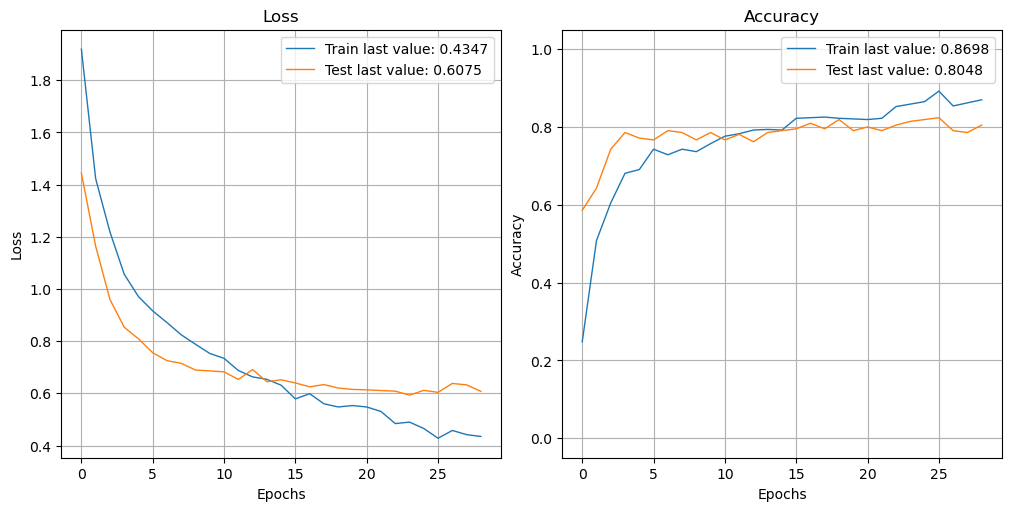

In [154]:
try:
    from plot_keras_history import show_history, plot_history
    import matplotlib.pyplot as plt

    show_history(history4)
    plot_history(history4, path="standard.png")
    plt.close()
except:
    epochs_range = range(len(history4.history['loss']))

    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history4.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history4.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history4.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history4.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

Correspondance des clusters :  [0 1 2 3 4 5 6]


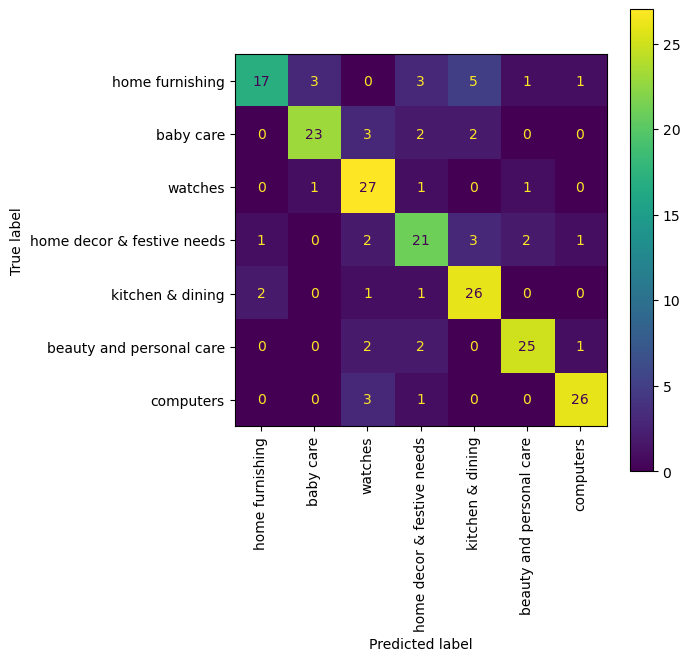

In [227]:
y_test_pred = np.argmax(model4.predict(X_test), axis=1)

y_test_pred_transform = conf_mat_transform(y_test_num, y_test_pred)
conf_mat = metrics.confusion_matrix(y_test_num, y_test_pred_transform)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=list_labels)
disp.plot()
plt.rcParams['figure.figsize']=[6,6]
plt.xticks(rotation=90)
plt.show()

In [228]:
print(metrics.classification_report(y_test_num, y_test_pred_transform))

              precision    recall  f1-score   support

           0       0.85      0.57      0.68        30
           1       0.85      0.77      0.81        30
           2       0.71      0.90      0.79        30
           3       0.68      0.70      0.69        30
           4       0.72      0.87      0.79        30
           5       0.86      0.83      0.85        30
           6       0.90      0.87      0.88        30

    accuracy                           0.79       210
   macro avg       0.80      0.79      0.78       210
weighted avg       0.80      0.79      0.78       210

